In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use("seaborn-whitegrid")

import seaborn as sns 
from collections import Counter

import warnings 
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Installation for Spark

In [2]:
!pip install spark

     |████████████████████████████████| 41 kB 32 kB/s 
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58738 sha256=7f5ac8571b02acbaabecc512fb3f171bea610395ee5a2707cf4a2bb5ee99882d
  Stored in directory: /root/.cache/pip/wheels/4e/0e/f1/164619f9920fb447d294afaae11a7715bd442ded7225953d72
Successfully built spark


In [3]:
!pip install pyspark

     |████████████████████████████████| 212.3 MB 13 kB/s 
     |████████████████████████████████| 198 kB 39.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=6158d366ef09f0ba20fb21ae1d6f22f38db235aa85a26bb3b5f584b1fe531ca1
  Stored in directory: /root/.cache/pip/wheels/43/47/42/bc413c760cf9d3f7b46ab7cd6590e8c47ebfd19a7386cd4a57
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [5]:
spark = SparkSession \
    .builder \
    .appName("Spark ,ML and Basic Analysis For Titanic") \
    .getOrCreate()

# Read File


In [6]:
Erdem_data = "/kaggle/input/titanic/train.csv"

In [7]:
titanic_df = spark.read.csv(Erdem_data,header = 'True',inferSchema='True')

In [8]:
display(titanic_df)

DataFrame[PassengerId: int, Survived: int, Pclass: int, Name: string, Sex: string, Age: double, SibSp: int, Parch: int, Ticket: string, Fare: double, Cabin: string, Embarked: string]

In [9]:
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



### Count of Passengers

In [10]:
passengers_count = titanic_df.count()
print(passengers_count)

891


In [11]:
titanic_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [12]:
titanic_df.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                null|  null| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [13]:
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



#  **Basic Analysis & Visualization**

In [14]:
titanic_df.select("Survived","Pclass","Embarked").show()

+--------+------+--------+
|Survived|Pclass|Embarked|
+--------+------+--------+
|       0|     3|       S|
|       1|     1|       C|
|       1|     3|       S|
|       1|     1|       S|
|       0|     3|       S|
|       0|     3|       Q|
|       0|     1|       S|
|       0|     3|       S|
|       1|     3|       S|
|       1|     2|       C|
|       1|     3|       S|
|       1|     1|       S|
|       0|     3|       S|
|       0|     3|       S|
|       0|     3|       S|
|       1|     2|       S|
|       0|     3|       Q|
|       1|     2|       S|
|       0|     3|       S|
|       1|     3|       C|
+--------+------+--------+
only showing top 20 rows



In [15]:
titanic_df.groupBy("Survived").count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



In [16]:
groupBy_output = titanic_df.groupBy("Survived").count()
display(groupBy_output)

DataFrame[Survived: int, count: bigint]

In [17]:
# Sex & Survived
titanic_df.groupBy("Sex","Survived").count().show()

+------+--------+-----+
|   Sex|Survived|count|
+------+--------+-----+
|  male|       0|  468|
|female|       1|  233|
|female|       0|   81|
|  male|       1|  109|
+------+--------+-----+



In [18]:
Fare_order=titanic_df.filter(titanic_df.SibSp > 0).groupby("SibSp").sum("Fare")

+-----+------------------+
|SibSp|         sum(Fare)|
+-----+------------------+
|    1|         9226.8004|
|    3|         1102.5418|
|    5|             234.5|
|    4| 573.3999999999999|
|    8|            486.85|
|    2|         1449.1041|
|    0|15620.752999999993|
+-----+------------------+



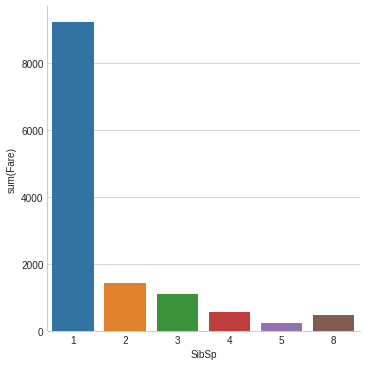

In [19]:
# SibSp & Fare  (Visualization)
Fifth = titanic_df.groupBy("SibSp")
Fifth.agg({'Fare':'sum'}).show()

Vis_fifth=Fare_order.toPandas()
Vis_fifth=Vis_fifth.reset_index()
Fare=sns.factorplot(data=Vis_fifth,x="SibSp",y="sum(Fare)",kind="bar",size=5)
plt.show()

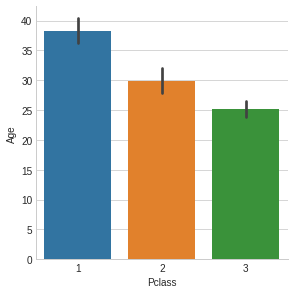

In [20]:
# Pclass & Age (Visualization)
Sixth_vis=titanic_df.toPandas()
Pclass=sns.factorplot(data=Sixth_vis,x="Pclass",y="Age",kind="bar",size=4)
plt.show()

# **Checking Null Values**

In [21]:
def null_value_count(df):
  null_columns_counts = []
  numRows = df.count()
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

In [22]:
null_columns_count_list = null_value_count(titanic_df)

In [23]:
spark.createDataFrame(null_columns_count_list, ['Column_With_Null_Value', 'Null_Values_Count']).show()

+----------------------+-----------------+
|Column_With_Null_Value|Null_Values_Count|
+----------------------+-----------------+
|                   Age|              177|
|                 Cabin|              687|
|              Embarked|                2|
+----------------------+-----------------+



### Age feature has 177 null values.

In [24]:
mean_age = titanic_df.select(mean('Age')).collect()[0][0]
print(mean_age)

29.69911764705882


In [25]:
titanic_df.select("Name").show()

+--------------------+
|                Name|
+--------------------+
|Braund, Mr. Owen ...|
|Cumings, Mrs. Joh...|
|Heikkinen, Miss. ...|
|Futrelle, Mrs. Ja...|
|Allen, Mr. Willia...|
|    Moran, Mr. James|
|McCarthy, Mr. Tim...|
|Palsson, Master. ...|
|Johnson, Mrs. Osc...|
|Nasser, Mrs. Nich...|
|Sandstrom, Miss. ...|
|Bonnell, Miss. El...|
|Saundercock, Mr. ...|
|Andersson, Mr. An...|
|Vestrom, Miss. Hu...|
|Hewlett, Mrs. (Ma...|
|Rice, Master. Eugene|
|Williams, Mr. Cha...|
|Vander Planke, Mr...|
|Masselmani, Mrs. ...|
+--------------------+
only showing top 20 rows



### To replace these NaN values, we can assign them the mean age of the dataset.But the problem is, there were many people with many different ages. We just cant assign a 4 year kid with the mean age that is 29 years.

### We can check the Name feature. Looking upon the feature, we can see that the names have a salutation like Mr or Mrs. Thus we can assign the mean values of Mr and Mrs to the respective groups****

In [26]:
titanic_df = titanic_df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))

### Using the Regex ""[A-Za-z]+)." we extract the initials from the Name. It looks for strings which lie between A-Z or a-z and followed by a .(dot).

In [27]:
titanic_df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|   Miss|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|    Mrs|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|     Mr|
|          6|   

In [28]:
titanic_df.select("Initial").distinct().show()

+--------+
| Initial|
+--------+
|     Don|
|    Miss|
|Countess|
|     Col|
|     Rev|
|    Lady|
|  Master|
|     Mme|
|    Capt|
|      Mr|
|      Dr|
|     Mrs|
|     Sir|
|Jonkheer|
|    Mlle|
|   Major|
|      Ms|
+--------+



### There are some misspelled Initials like Mlle or Mme that stand for Miss. I will replace them with Miss and same thing for other values.

In [29]:
titanic_df = titanic_df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
               ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

In [30]:
titanic_df.select("Initial").distinct().show()

+-------+
|Initial|
+-------+
|   Miss|
|  Other|
| Master|
|     Mr|
|    Mrs|
+-------+



### Lets check the average age by Initials

In [31]:
titanic_df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

### Let's impute missing values in age feature based on average age of Initials

In [32]:
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Miss") & (titanic_df["Age"].isNull()), 22).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Other") & (titanic_df["Age"].isNull()), 46).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Master") & (titanic_df["Age"].isNull()), 5).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Mr") & (titanic_df["Age"].isNull()), 33).otherwise(titanic_df["Age"]))
titanic_df = titanic_df.withColumn("Age",when((titanic_df["Initial"] == "Mrs") & (titanic_df["Age"].isNull()), 36).otherwise(titanic_df["Age"]))

### Check the imputation

In [33]:
titanic_df.filter(titanic_df.Age==46).select("Initial").show()

+-------+
|Initial|
+-------+
|     Mr|
|     Mr|
|     Mr|
+-------+



In [34]:
titanic_df.select("Age").show()

+----+
| Age|
+----+
|22.0|
|38.0|
|26.0|
|35.0|
|35.0|
|33.0|
|54.0|
| 2.0|
|27.0|
|14.0|
| 4.0|
|58.0|
|20.0|
|39.0|
|14.0|
|55.0|
| 2.0|
|33.0|
|31.0|
|36.0|
+----+
only showing top 20 rows



### Embarked feature has only two missining values. Let's check values within Embarked

In [35]:
titanic_df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



### Majority Passengers boarded from "S". We can impute with "S"

In [36]:
titanic_df = titanic_df.na.fill({"Embarked" : 'S'})

### We can drop Cabin features as it has lots of null values

In [37]:
titanic_df = titanic_df.drop("Cabin")
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- Initial: string (nullable = true)



## We can create a new feature called "Family_size" and "Alone" and analyse it. This feature is the summation of Parch(parents/children) and SibSp(siblings/spouses). It gives us a combined data so that we can check if survival rate have anything to do with family size of the passengers

In [38]:
titanic_df = titanic_df.withColumn("Family_Size",col('SibSp')+col('Parch'))

In [39]:
titanic_df.groupBy("Family_Size").count().show()

+-----------+-----+
|Family_Size|count|
+-----------+-----+
|          1|  161|
|          6|   12|
|          3|   29|
|          5|   22|
|          4|   15|
|          7|    6|
|         10|    7|
|          2|  102|
|          0|  537|
+-----------+-----+



In [40]:
titanic_df = titanic_df.withColumn('Alone',lit(0))

In [41]:
titanic_df = titanic_df.withColumn("Alone",when(titanic_df["Family_Size"] == 0, 1).otherwise(titanic_df["Alone"]))

In [42]:
titanic_df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked',
 'Initial',
 'Family_Size',
 'Alone']

# ***Machine Learning***

## Lets convert Sex, Embarked & Initial columns from string to number using StringIndexer

In [43]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(titanic_df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
titanic_df = pipeline.fit(titanic_df).transform(titanic_df)

In [44]:
titanic_df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+---------+--------------+-------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+-----------+-----+---------+--------------+-------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|          1|    0|      0.0|           0.0|          0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|          1|    0|      1.0|           1.0|          2.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|          0|  

In [45]:
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = false)
 |-- Initial: string (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)



## Drop columns which are not required

In [46]:
titanic_df = titanic_df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")
titanic_df.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|
|       0|     3|33.0|    0|    0| 8.4583|          0|    1|      0.0|           2.0|          0.0|
|       0|     1|54.0|    0|    0|51.8625|          0|    1|      0.0|           0.0|          0.0|


### Let's put all features into vector

In [47]:
feature = VectorAssembler(inputCols=titanic_df.columns[1:],outputCol="features")
feature_vector= feature.transform(titanic_df)

In [48]:
feature_vector.show()

+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+--------------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Family_Size|Alone|Sex_index|Embarked_index|Initial_index|            features|
+--------+------+----+-----+-----+-------+-----------+-----+---------+--------------+-------------+--------------------+
|       0|     3|22.0|    1|    0|   7.25|          1|    0|      0.0|           0.0|          0.0|(10,[0,1,2,4,5],[...|
|       1|     1|38.0|    1|    0|71.2833|          1|    0|      1.0|           1.0|          2.0|[1.0,38.0,1.0,0.0...|
|       1|     3|26.0|    0|    0|  7.925|          0|    1|      1.0|           0.0|          1.0|[3.0,26.0,0.0,0.0...|
|       1|     1|35.0|    1|    0|   53.1|          1|    0|      1.0|           0.0|          2.0|[1.0,35.0,1.0,0.0...|
|       0|     3|35.0|    0|    0|   8.05|          0|    1|      0.0|           0.0|          0.0|(10,[0,1,4,6],[3....|
|       0|     3|33.0|    0|    

### Now that the data is all set, let's split it into training and test. I'll be using 80% of it.

In [49]:
(trainingData, testData) = feature_vector.randomSplit([0.8, 0.2],seed = 11)

# Modelling

## Here is the list of few Classification Algorithms from Spark ML

### -LogisticRegression
### -DecisionTreeClassifier
### -RandomForestClassifier
### -Gradient-boosted tree classifier
### -NaiveBayes
### -Support Vector Machine

# LogisticRegression

In [50]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Survived", featuresCol="features")
#Training algo
lrModel = lr.fit(trainingData)
lr_prediction = lrModel.transform(testData)
lr_prediction.select("prediction", "Survived", "features").show()
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [51]:
lr_accuracy = evaluator.evaluate(lr_prediction)
print("Accuracy of LogisticRegression is = %g"% (lr_accuracy))
print("Test Error of LogisticRegression = %g " % (1.0 - lr_accuracy))

Accuracy of LogisticRegression is = 0.771277
Test Error of LogisticRegression = 0.228723 


# DecisionTreeClassifier

In [52]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="Survived", featuresCol="features")
dt_model = dt.fit(trainingData)
dt_prediction = dt_model.transform(testData)
dt_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [53]:
dt_accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTreeClassifier is = %g"% (dt_accuracy))
print("Test Error of DecisionTreeClassifier = %g " % (1.0 - dt_accuracy))

Accuracy of DecisionTreeClassifier is = 0.819149
Test Error of DecisionTreeClassifier = 0.180851 


# RandomForestClassifier

In [54]:
from pyspark.ml.classification import RandomForestClassifier
rf = DecisionTreeClassifier(labelCol="Survived", featuresCol="features")
rf_model = rf.fit(trainingData)
rf_prediction = rf_model.transform(testData)
rf_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [55]:
rf_accuracy = evaluator.evaluate(rf_prediction)
print("Accuracy of RandomForestClassifier is = %g"% (rf_accuracy))
print("Test Error of RandomForestClassifier  = %g " % (1.0 - rf_accuracy))

Accuracy of RandomForestClassifier is = 0.819149
Test Error of RandomForestClassifier  = 0.180851 


# Gradient-boosted tree classifier

In [56]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="Survived", featuresCol="features",maxIter=10)
gbt_model = gbt.fit(trainingData)
gbt_prediction = gbt_model.transform(testData)
gbt_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [57]:
gbt_accuracy = evaluator.evaluate(gbt_prediction)
print("Accuracy of Gradient-boosted tree classifie is = %g"% (gbt_accuracy))
print("Test Error of Gradient-boosted tree classifie %g"% (1.0 - gbt_accuracy))

Accuracy of Gradient-boosted tree classifie is = 0.803191
Test Error of Gradient-boosted tree classifie 0.196809


# NaiveBayes

In [58]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="Survived", featuresCol="features")
nb_model = nb.fit(trainingData)
nb_prediction = nb_model.transform(testData)
nb_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|(10,[0,1,2,4,5],[...|
|       1.0|       0|(10,[0,1,3,4,5],[...|
|       1.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       1.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       1.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [59]:
nb_accuracy = evaluator.evaluate(nb_prediction)
print("Accuracy of NaiveBayes is  = %g"% (nb_accuracy))
print("Test Error of NaiveBayes  = %g " % (1.0 - nb_accuracy))

Accuracy of NaiveBayes is  = 0.739362
Test Error of NaiveBayes  = 0.260638 


# Support Vector Machine

In [60]:
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(labelCol="Survived", featuresCol="features")
svm_model = svm.fit(trainingData)
svm_prediction = svm_model.transform(testData)
svm_prediction.select("prediction", "Survived", "features").show()

+----------+--------+--------------------+
|prediction|Survived|            features|
+----------+--------+--------------------+
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,6],[1.0,...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,3,4,5],[...|
|       0.0|       0|(10,[0,1,2,4,5],[...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|[1.0,58.0,0.0,2.0...|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6],[1....|
|       0.0|       0|(10,[0,1,4,6,8],[...|
|       0.0|       0|[2.0,19.0,1.0,1.0...|
+----------

In [61]:
svm_accuracy = evaluator.evaluate(svm_prediction)
print("Accuracy of Support Vector Machine is = %g"% (svm_accuracy))
print("Test Error of Support Vector Machine = %g " % (1.0 - svm_accuracy))

Accuracy of Support Vector Machine is = 0.808511
Test Error of Support Vector Machine = 0.191489 


# ------------------------------------------------------------------